### Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, September 29, 2016 11:59 PM


#### Submission Instructions
To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Make sure to share the private repo with my github account (mdog) and submit the repo path through blackboard.

---

## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Load Python modules

In [8]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO
from io import BytesIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations

## Problem 3: Is the average of polls better than just one poll?

#### Problem 3(a)

Most undecided voters vote for one of the two candidates at the election. Therefore, the reported percentages underestimate the final value of both candidates. However, if we assume the undecided will split evenly, then the observed difference should be an unbiased estimate of the final difference. 

Add a new column to the `election` DataFrame containg the difference between Obama and Romeny called `Diff`. 

In [10]:
url = 'http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv'
request = requests.get(url)
election = pd.read_csv(BytesIO(request.content))
election['Diff'] = election['Obama']/100.0 - election['Romney']/100.0
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,Diff
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,0.00
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,0.02
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,0.00
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1,0.01
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1,-0.01


#### Problem 3(b)

Make a plot of the differences for the week before the election (e.g. 5 days) where the days are on the x-axis and the differences are on the y-axis.  Add a horizontal line showing 3.9%: the difference between Obama and Romney on election day.

In [25]:
import warnings
warnings.filterwarnings('ignore')
election_Nov_2012 = election[( (election['Start Date'] >= '2012-11-01') & (election['Start Date'] <= '2012-11-30'))]
election_Nov_2012.drop_duplicates('Start Date', inplace = True)
election_Nov_2012['Start Date']

0    2012-11-04
1    2012-11-03
7    2012-11-01
8    2012-11-02
Name: Start Date, dtype: object

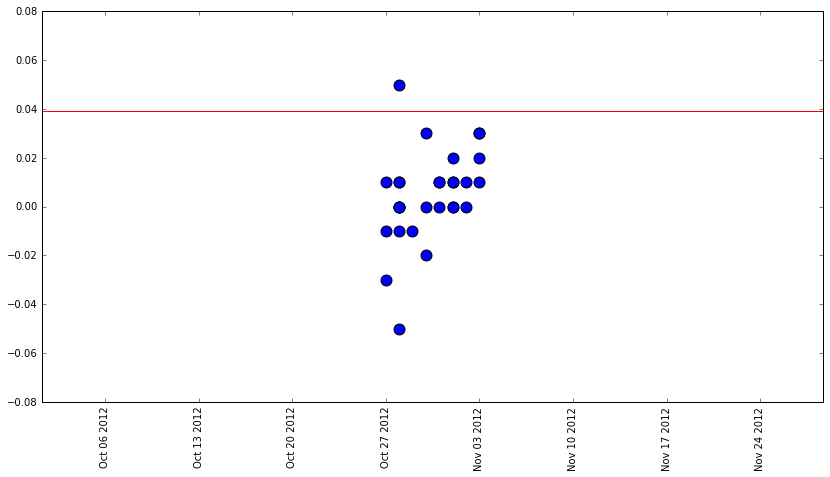

In [31]:
electionNov_pre_5d = election[( (election['End Date'] >= '2012-10-27') & (election['End Date'] <= '2012-11-03'))]
plt.figure(figsize=(14,7))
plt.scatter(pd.to_datetime(electionNov_pre_5d['End Date']).values, electionNov_pre_5d['Diff'].values, s=120)
plt.axhline(y=0.039, color = 'r')
plt.xticks( rotation='vertical')
plt.show()


#### Problem 3(c) 

Make a plot showing the differences by pollster where the pollsters are on the x-axis and the differences on the y-axis. 

In [92]:
#electionNov_pre_5d.drop_duplicates("Pollster", inplace = True)
pollsters_idx = np.array(electionNov_pre_5d.index)
pollsters_id  = {}
for i in range(len(pollsters_idx)):
    pollsters_id[pollsters_idx[i]] = i
pollsters_id

{16: 0,
 17: 1,
 18: 2,
 19: 3,
 20: 4,
 21: 5,
 22: 6,
 23: 7,
 24: 8,
 25: 9,
 27: 10,
 28: 11,
 29: 12,
 30: 13,
 32: 14,
 34: 15,
 36: 16,
 37: 17,
 38: 18,
 39: 19,
 41: 20,
 44: 21}

Is the *across poll* difference larger than the *between pollster* difference? 

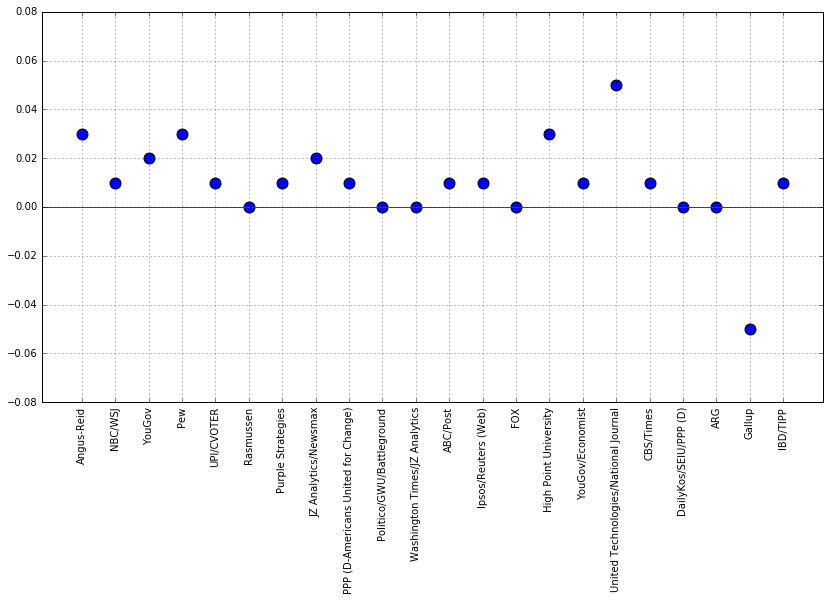

In [93]:
X = [pollsters_id[pollster] for pollster in pollsters_idx]
plt.figure(figsize=(14,7))
plt.xticks(X, electionNov_pre_5d['Pollster'].values)
plt.xticks( rotation='vertical')
plt.scatter(X, electionNov_pre_5d['Diff'].values, s=120)
plt.axhline(y=0, color = 'r')
plt.grid(True)
plt.show()


Answer: The difference accross the polls is lage than the between pollsters  

#### Problem 3(d)

Take the average for each pollster and then compute the average of that. Given this difference how confident would you have been of an Obama victory?

**Hint**: Compute an estimate of the SE of this average based exclusively on the observed data. 

In [96]:
tmp = election.loc[:,['Pollster','Diff']].copy()
tmp.head()

,Pollster,Diff
0,Politico/GWU/Battleground,0.00
1,YouGov/Economist,0.02
2,Gravis Marketing,0.00
3,IBD/TIPP,0.01
4,Rasmussen,-0.01


In [106]:
Means = tmp.groupby(tmp.Pollster).mean()
Means = Means.reset_index()
Means.head()

,Pollster,Diff
0,ABC/Post,0.008571
1,AP-GfK,0.028750
2,ARG,-0.002500
3,Allstate/National Journal,0.070000
4,Angus-Reid,0.006667


In [110]:
print("The average Percentage difference is: " + str(np.mean(Means['Diff'].values)))
print("The average Standard Error is: " + str(np.mean(np.std(Means['Diff'].values))))

The average Percentage difference is: 0.0253311271799
The average Standard Error is: 0.0275264307425


Answer: The Mean Percentage difference is +2.5% for Pres. Obama; however, the standard error is 2.7% and the fact that Mean Percentage is within the standard error, I wouldnt have been very confident with Obama's victory.

#### Problem 3(e)

Show the difference against time and see if you can detect a trend towards the end. Use this trend to see if it improves the final estimate.

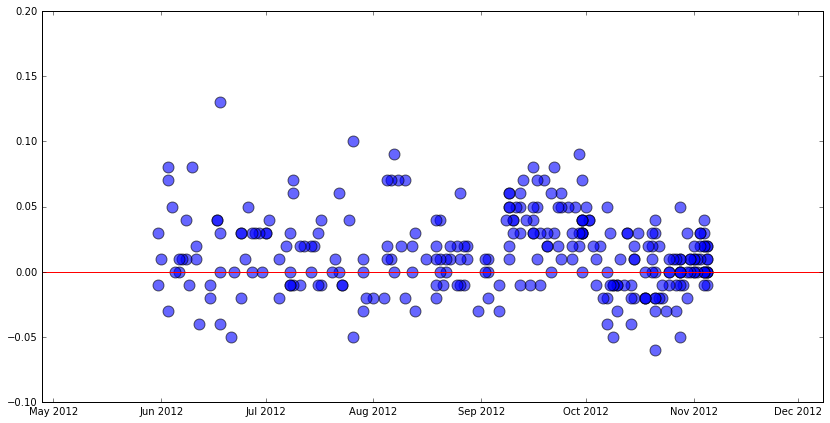

In [123]:
plt.figure(figsize=(14,7))
#polls After Romney had Won the GOP nomination in 2012
polls_1_n_1 = polls2012 = election[election['End Date']>'2012-05-30'] 
plt.scatter(pd.to_datetime(polls_1_n_1['End Date']).values, polls_1_n_1['Diff'].values, s=120, alpha = 0.6)
plt.axhline(y=0, c='r')
plt.show()

Answer: From mid August, the polling results has been pretty consistent among pollsters; in other words, the polling data were pretty much the same. So for example: if one poll showed that obama was leading, other polls would come to the same conculusion; hence, any lead or tie was actually real and it was the true reflection of the voters. Thus, the polls were accurate.

## Discussion for Problem 3

Average of polls overtime is really helpful in determinining the trajectory of a Presidential Race in the US.

---


# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Make sure to share the private repo with my github account (mdog) and submit the repo path through blackboard.